## Introduction ##
The aim of this exercise is to encourage you to use the methods we saw in class
on a more realistic application than the Asterix dataset. We will use data provided
by the company LendingClub. The data has been used on several research papers
see e.g. Jagtiani and Lemieux (2019); Malekipirbazari and Aksakalli (2015). The
exercise is based on material from Hull (2020). This data was made available from
LendingClub when its main business was peer-to-peer lending. In 2020 the company
has abandoned the peer-to-peer lending platform.  
We will use the dataset to develop a classification algorithm to determine whether
borrowers should be accepted or rejected for a loan.  
The full data is in the following file: l endingclubFullDataSet.xlsx. You can
read the meaning of each column by examining the file: lendingclubdatadictionary.xlsx.  
We will focus on loans that have been completed either as ”Fully Paid” or
”Charged Off” in Column ’O’. The problem is to develop a classification algorithm
to predict which loans will be ”Fully Paid” and which will be ”Charged Off”.  
Out of the 25000 loans there are 12,290 loans that have already been classified.
We will concentrate on this dataset. To make the exercise a bit simpler the data (of
12,290 loans) is already split into a train/test/validate datasets in the following files:
- lendingclubtraindata.xlsx
- lendingclubtestdata.xlsx
- lendingclubvaldata.xlsx
To be concrete we associate a value of 1 when the loan was paid and 0 when it
was not (see column E in the excel files aboveloan_status). We also dropped most
of the columns from the dataset and just focus on the ones below.
- Home ownership
- Income per annum (USD)
- Dept to income ratio (in %)
Since home ownership is categorical we used 0 if the borrower was renting and 1 if they owned a home.

Import the library.

Import the data.

In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz, export_text
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [5]:
df_train = pd.read_excel('./data/lendingclubtraindata.xlsx')
df_val = pd.read_excel('./data/lendingclubvaldata.xlsx')
df_test = pd.read_excel('./data/lendingclubtestdata.xlsx')

In [6]:
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(7000, 5)
(3000, 5)
(2290, 5)


In [7]:
df_train.head()

,home_ownership,income,dti,fico,loan_status
0,1,44304.0,18.47,690,0
1,0,50000.0,29.62,735,1
2,0,64400.0,16.68,675,1
3,0,38500.0,33.73,660,0
4,1,118000.0,26.66,665,1


In [50]:
df_val.head()

,homw_ownership,income,dti,fico,loan_status
0,0,25000.0,27.60,660,0
1,0,50000.0,21.51,715,1
2,1,100000.0,8.14,770,1
3,0,75000.0,1.76,685,0
4,1,78000.0,16.11,680,1


In [51]:
df_test.head()

,home_ownership,income,dti,fico,loan_status
0,1,52400.0,24.64,665,1
1,1,150000.0,17.04,785,1
2,1,100000.0,20.92,710,1
3,0,97000.0,13.11,705,1
4,1,100000.0,24.08,685,0


Create the feature and target dataframes.

In [8]:
X_train = df_train.drop(columns = ['loan_status'])
X_val = df_val.drop(columns = ['loan_status'])
X_test = df_test.drop(columns = ['loan_status'])

Y_train = df_train['loan_status']
Y_val = df_val['loan_status']
Y_test = df_test['loan_status']

In [9]:
X_train.head()

,home_ownership,income,dti,fico
0,1,44304.0,18.47,690
1,0,50000.0,29.62,735
2,0,64400.0,16.68,675
3,0,38500.0,33.73,660
4,1,118000.0,26.66,665


In [10]:
Y_train.head()

0    0
1    1
2    1
3    0
4    1
Name: loan_status, dtype: int64

In [11]:
type(Y_train)

pandas.core.series.Series

**Exercise 1** Using the data from the training data set calculate the initial entropy
of the dataset using the empirical probability that the loan is paid of.

In [12]:
Y_train.value_counts()

loan_status
1    5542
0    1458
Name: count, dtype: int64

In [46]:
#the probability of training set.
p_train = Y_train.sum()/len(Y_train)

In [47]:
p_train

np.float64(0.7917142857142857)

In [64]:
#create a function of calculating entropy:
def calculate_entropy(p) -> float:
    return -(p*np.log(p)+(1-p)*np.log(1-p))

In [65]:
Entropy_train = calculate_entropy(p_train)

In [66]:
print(f'The initial entropy of the training data set is {Entropy_train:.4f}.')

The initial entropy of the training data set is 0.5117.


**Exercise 2** Calculate the information gain (i.e. reduction in expected entropy) if
the home ownership feature is used to build a simple classification tree.

In [69]:
df_train['home_ownership'].value_counts()

home_ownership
1    4228
0    2772
Name: count, dtype: int64

In [70]:
df_train_home = df_train[df_train['home_ownership']==1]
df_train_no_home = df_train[df_train['home_ownership']==0]

In [72]:
p_train_home = df_train_home['loan_status'].sum()/len(df_train_home)
p_train_no_home = df_train_no_home['loan_status'].sum()/len(df_train_no_home)

In [73]:
print(p_train_home)
print(p_train_no_home)

0.8171712393566698
0.7528860028860029


We can see that with the split of home ownership, the probabilities rises for those who owns home.

In [74]:
Entropy_train_home = calculate_entropy(p_train_home)
Entropy_train_no_home = calculate_entropy(p_train_no_home)

In [75]:
print(f'The entropy of the training data set with home is {Entropy_train_home:.4f}, with no home is {Entropy_train_no_home:.4f}.')

The entropy of the training data set with home is 0.4757, with no home is 0.5591.


**Exercise 3** Use the DecisionTreeClassifier from the Python library sklearn to
produce a decision tree. Experiment with different parameters. Use the parameters:
$$criterion=entropy$$ $$max depth=4$$ $$min samples split=1000$$
$$min samples leaf=200$$ $$random state=0,$$
to produce an initial tree. Experiment with the different techniques we discussed in
the lecture to improve the initial tree. You could use other features from the dataset,
and/or other algorithms. You can also develop a regression tree by trying to predict
the level of interest to be applied on a loan.

In [105]:
#Define the classifier with the suggested values.
clf = DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_split=1000, min_samples_leaf=200, random_state=0)

In [106]:
#train the classifier
clf = clf.fit(X_train,Y_train)

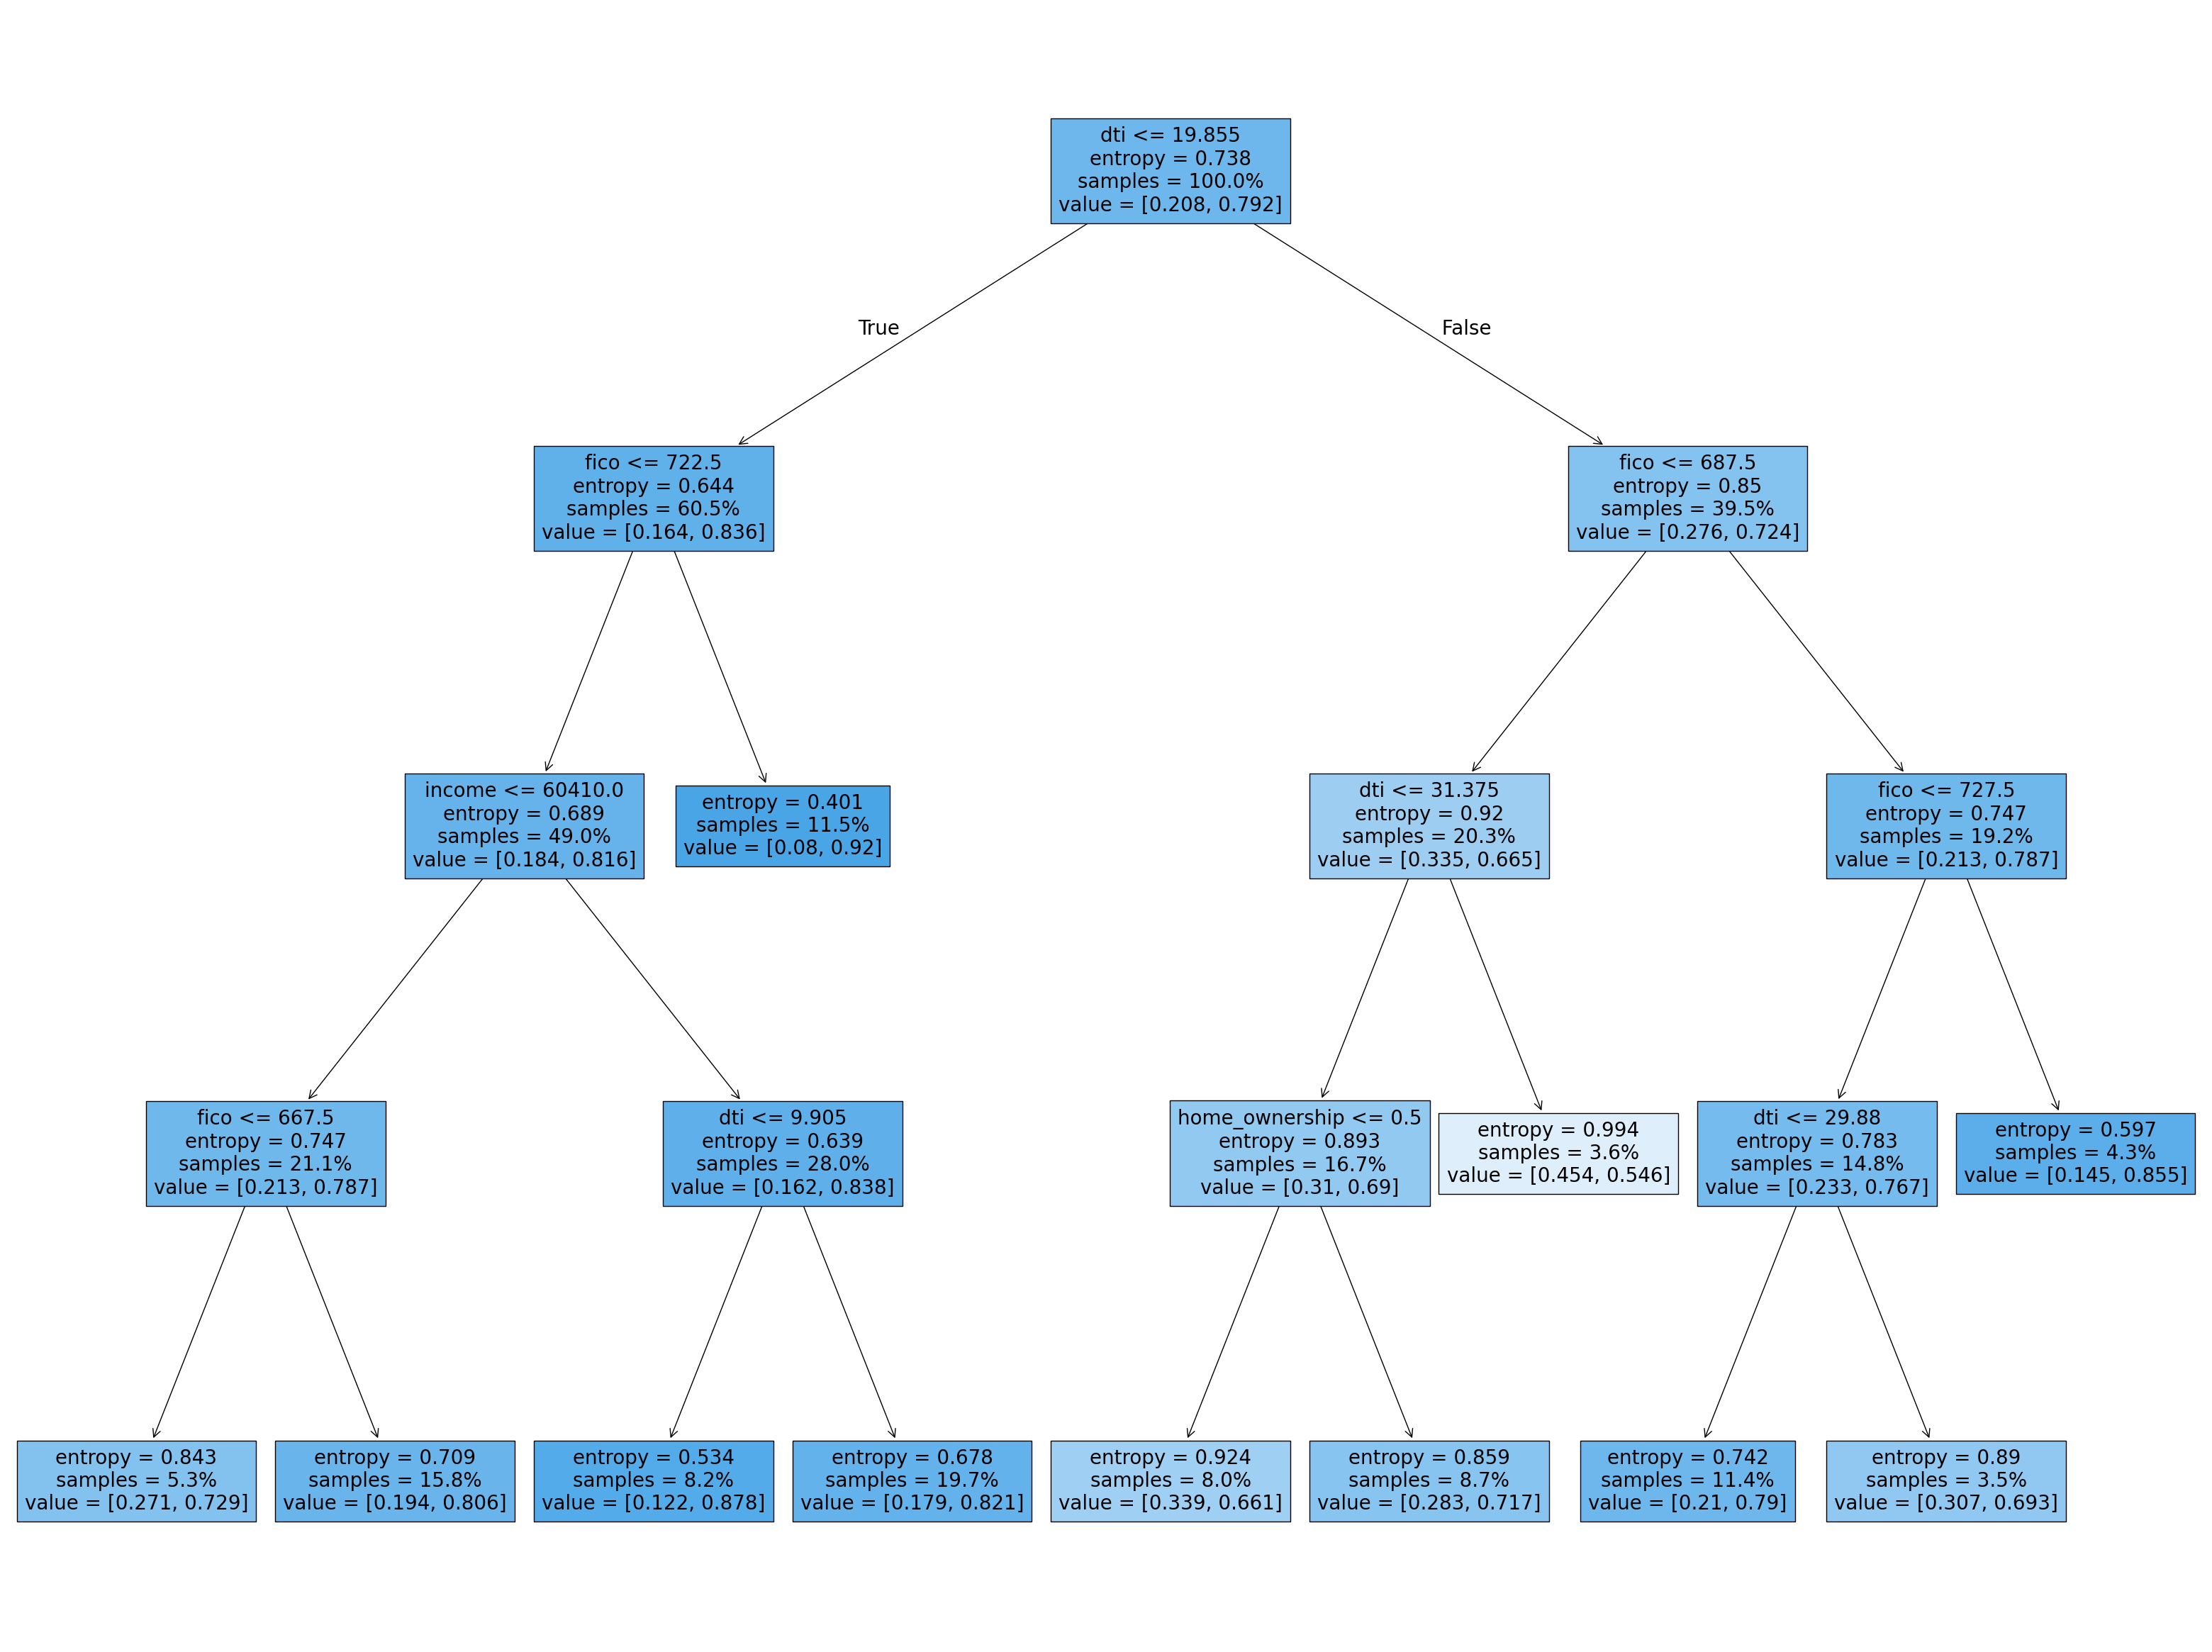

In [107]:
fig, ax = plt.subplots(figsize=(40, 30))
plot_tree(clf, filled=True, feature_names=X_train.columns, proportion=True)
plt.show()

This is a terrible classifier as the entrofies are so high at the end.

In [108]:
train_score=clf.score(X_train,Y_train)
test_score=clf.score(X_test,Y_test)

print('train_score=',train_score)
print('test_score=',test_score)

train_score= 0.7917142857142857
test_score= 0.7917030567685589


Vary the parameters to see the differences:

In [119]:
max_depths = [3,10,20]
min_samples_splits = [50, 100, 1000]
min_samples_leaves = [10, 50, 200]

# DataFrame to store results
results = []

# Loop through different hyperparameter combinations
for depth in max_depths:
    for min_split in min_samples_splits:
        for min_leaf in min_samples_leaves:
            # Train Decision Tree
            clf = DecisionTreeClassifier(criterion='entropy', max_depth=depth, 
                                         min_samples_split=min_split, min_samples_leaf=min_leaf, 
                                         random_state=0)
            clf.fit(X_train, Y_train)

            # Compute scores
            train_score = clf.score(X_train, Y_train)
            test_score = clf.score(X_test, Y_test)

            # Store results
            results.append({
                "max_depth": depth,
                "min_samples_split": min_split,
                "min_samples_leaf": min_leaf,
                "train_score": train_score,
                "test_score": test_score
            })

# Convert to DataFrame
df_results = pd.DataFrame(results)

# Display the DataFrame
print(df_results)

    max_depth  min_samples_split  min_samples_leaf  train_score  test_score
0           3                 50                10     0.791714    0.791703
1           3                 50                50     0.791714    0.791703
2           3                 50               200     0.791714    0.791703
3           3                100                10     0.791714    0.791703
4           3                100                50     0.791714    0.791703
5           3                100               200     0.791714    0.791703
6           3               1000                10     0.791714    0.791703
7           3               1000                50     0.791714    0.791703
8           3               1000               200     0.791714    0.791703
9          10                 50                10     0.801286    0.785153
10         10                 50                50     0.793857    0.790393
11         10                 50               200     0.791714    0.791703
12         1

It looks like varying the parameters has limited impacts to the scores, but imposes risks of over-fitting.

**Use bagging to optimze the classifier.**

In [123]:
# Define Random Forest (Bagging)
bagging_clf = RandomForestClassifier(n_estimators=100, max_depth=4, min_samples_split=1000, 
                                     min_samples_leaf=200, random_state=0)
bagging_clf.fit(X_train, Y_train)

# Evaluate performance
train_score = bagging_clf.score(X_train, Y_train)
test_score = bagging_clf.score(X_test, Y_test)

print(f"Bagging Train Score: {train_score:.4f}")
print(f"Bagging Test Score: {test_score:.4f}")

Bagging Train Score: 0.7917
Bagging Test Score: 0.7917


Since bagging can prevent overfitting, let's try some higher depth.

In [128]:
# Define Random Forest (Bagging)
bagging_clf = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=1000, 
                                     min_samples_leaf=200, random_state=0)
bagging_clf.fit(X_train, Y_train)

# Evaluate performance
train_score = bagging_clf.score(X_train, Y_train)
test_score = bagging_clf.score(X_test, Y_test)

print(f"Bagging Train Score: {train_score:.4f}")
print(f"Bagging Test Score: {test_score:.4f}")

Bagging Train Score: 0.7917
Bagging Test Score: 0.7917


It doesn't make too much change.

**Use XGBoost to optimize the classifier.**

In [149]:
# Define XGBoost (Boosting)
boosting_clf = XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.05,
                             min_child_weight=1, random_state=0)
boosting_clf.fit(X_train, Y_train)

# Evaluate performance
train_score = boosting_clf.score(X_train, Y_train)
test_score = boosting_clf.score(X_test, Y_test)

print(f"Boosting Train Score: {train_score:.4f}")
print(f"Boosting Test Score: {test_score:.4f}")

Boosting Train Score: 0.7973
Boosting Test Score: 0.7930


It looks like the algorithm wil not impact the results too much. To improve the prediction, we still need work more from the data side.